In [68]:
import numpy as np
from random import sample
from tqdm import tqdm
import pickle
import scipy.io
from scipy import signal
import itertools
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, kpss

from sklearn import linear_model, svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
mat = scipy.io.loadmat('PowerValuesOctMay.mat')
m = mat['MeasurementsTotal']

In [5]:
m = np.squeeze(m)

# Data Exploration

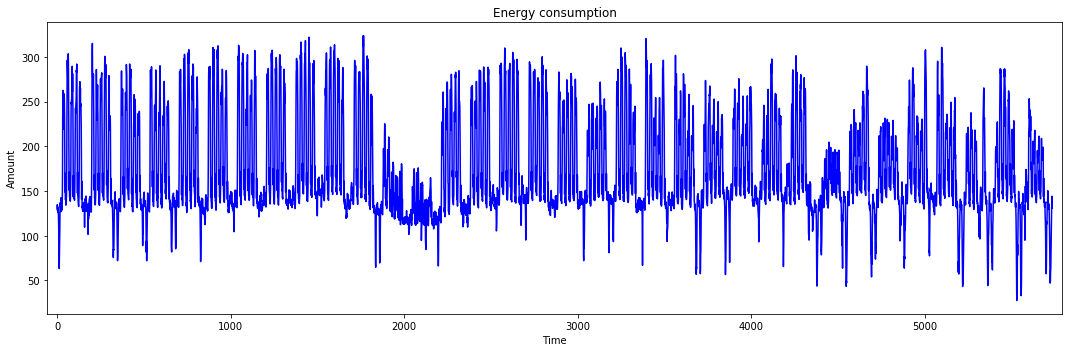

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

ax.plot(m, c='b')
ax.set_title('Energy consumption')
ax.set_xlabel('Time')
ax.set_ylabel('Amount')
ax.margins(x=0.01)
plt.tight_layout()
plt.savefig('p1_complete_data.png', dpi=300)
plt.show()

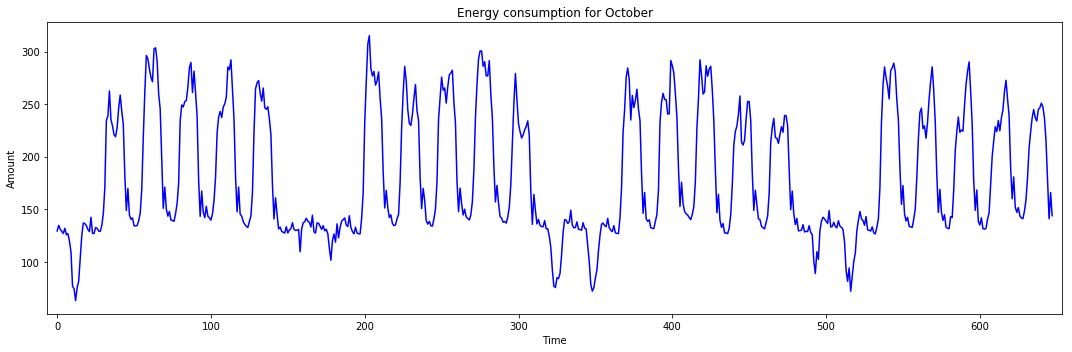

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

ax.plot(m[:27*24], c='b')
ax.set_title('Energy consumption for October')
ax.set_xlabel('Time')
ax.set_ylabel('Amount')
ax.margins(x=0.01)
plt.tight_layout()
plt.savefig('p1_october_data.png', dpi=300)
plt.show()

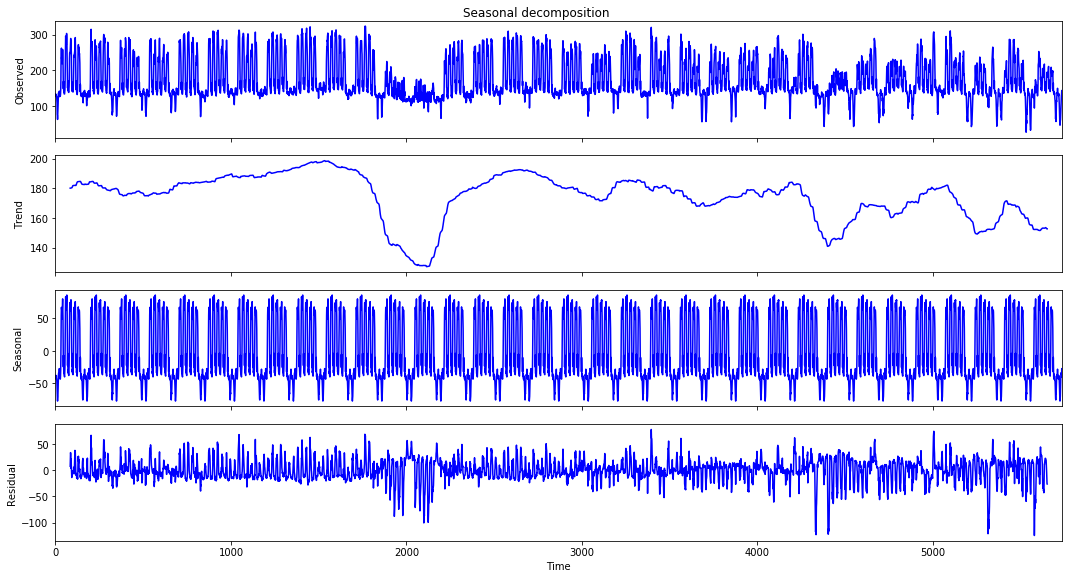

In [11]:
matplotlib.rcParams['figure.figsize'] = [15.0, 8.0]

sd = seasonal_decompose(m, model='additive', freq=168)


fig = sd.plot()
fig.suptitle('Seasonal decomposition', y=1.0)
plt.tight_layout()
plt.savefig('p1_decomposition.png', dpi=300)
plt.show()

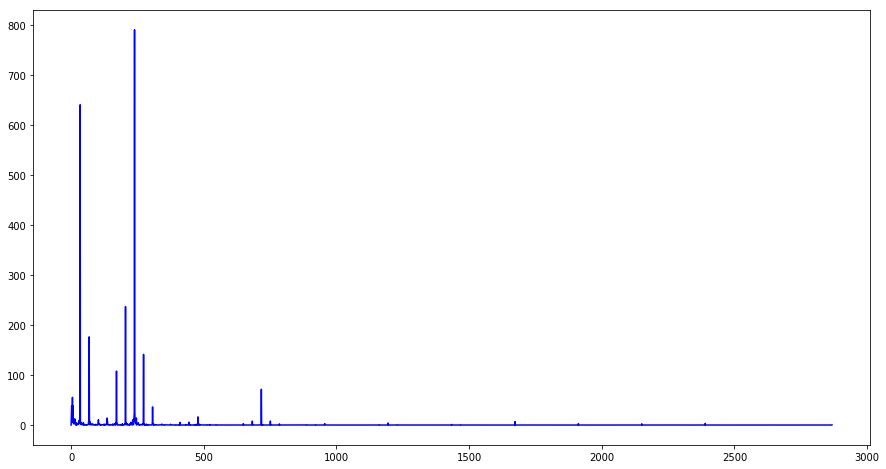

In [12]:
f, Pxx = signal.periodogram(m, scaling='spectrum')
plt.plot(Pxx)

In [13]:
tmp = Pxx.copy()
tmp.sort()
max_values = tmp[-2:]
max_freqs = [list(Pxx).index(v) for v in max_values]
print('Freq1: {:.2f} Freq2: {:.2f}'.format(1/max_freqs[1]*len(m), 1/max_freqs[0]*len(m)))

Freq1: 24.00 Freq2: 168.71


# Model fitting

## Split data in train and test samples

In [6]:
ratio_test = 0.1
num_samples = len(m)
index_split = int(num_samples*(1-ratio_test))
train = m[:index_split]
test = m[index_split:]
print('We have {} samples for training and {} samples for testing.'.format(len(train), len(test)))

We have 5162 samples for training and 574 samples for testing.


## Differencing filter

In [7]:
def apply_differencing_filter(ts, lag):
    num_samples = len(ts)
    return ts[lag:num_samples] - ts[:num_samples-lag]
def apply_differencing_filters(ts, lags):
    for lag in lags:
        ts = apply_differencing_filter(ts, lag)
    return ts

[(1,), (24,), (168,), (1, 24), (1, 168), (24, 168), (1, 24, 168)]


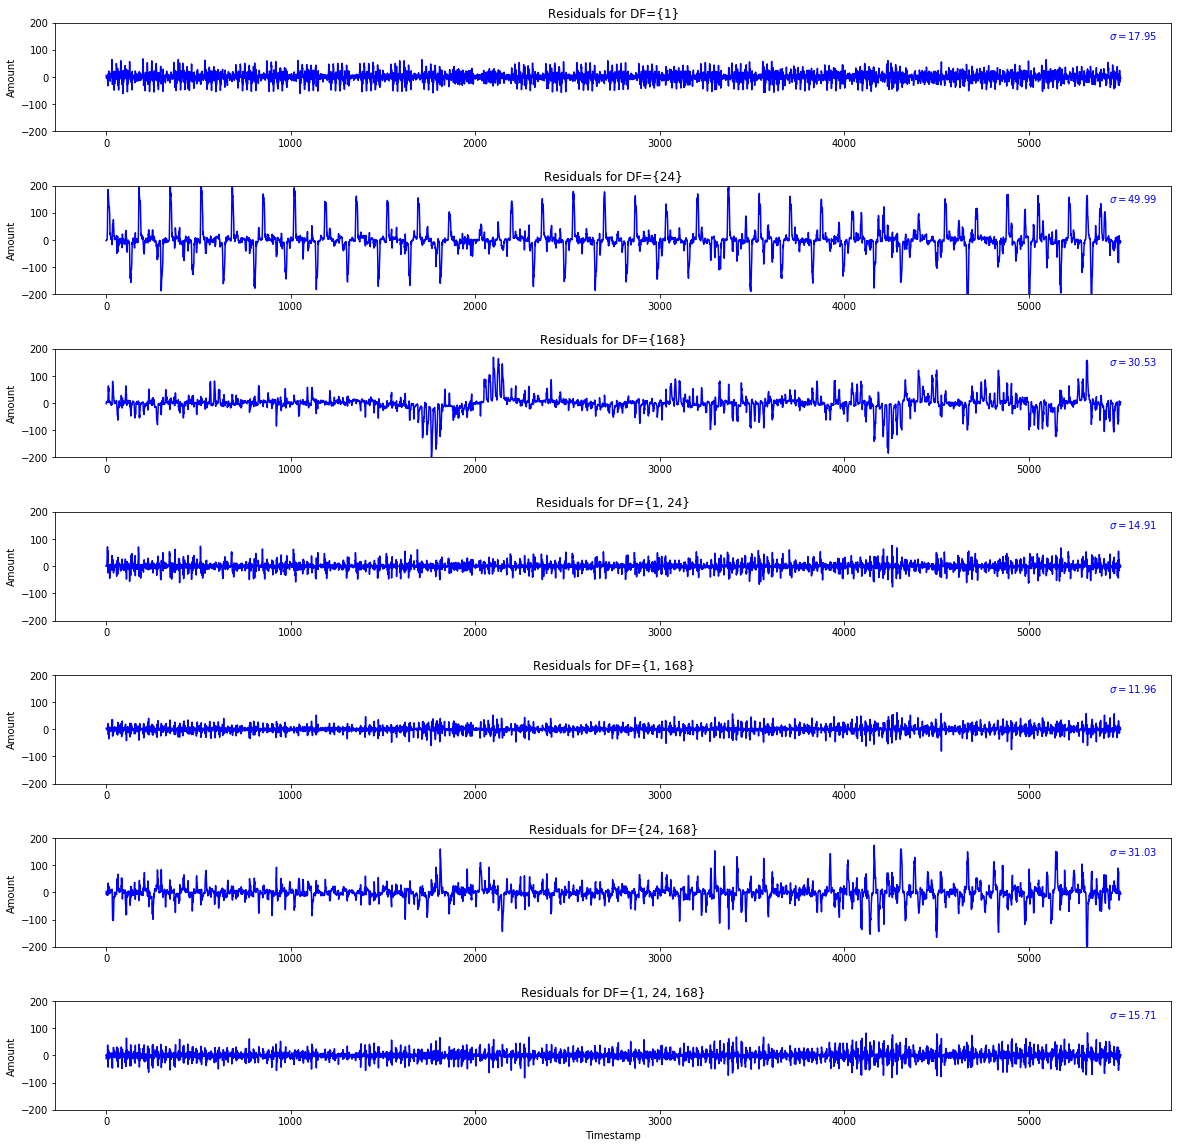

In [8]:
lags = [1, 24, 168]
combinations = []
for l in range(1,len(lags)+1):
    combinations.extend(list(itertools.combinations(lags, l)))
print(combinations)
m_diff = m
thres = 5500
fig, ax = plt.subplots(len(combinations), 1, figsize=(20,20))
plt.subplots_adjust(hspace = 0.5)
for i, lags in enumerate(combinations):
    
    m_diff = apply_differencing_filters(m, lags)[:thres]
    mean = np.mean(m_diff)
    std = np.std(m_diff)
    
    ax[i].text(5700, 130, r'$\sigma=${:.2f}'.format(std), ha='right', va='bottom', color='b')
    ax[i].plot(m_diff, c='b')
    ax[i].set_ylabel('Amount')
    ax[i].set_ylim([-200,200])
    if len(lags) == 1:
        ax[i].set_title('Residuals for DF={{{}}}'.format(str(lags)[1:-2]))
    else:
        ax[i].set_title('Residuals for DF={{{}}}'.format(str(lags)[1:-1]))
ax[-1].set_xlabel('Timestamp')
#plt.tight_layout()
#plt.savefig('data.png', dpi=300)
plt.show()

In [52]:
def plot_predictions(residuals, model, train, test, num_obs, name):

    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    # prepare array for plots
    x = np.arange(num_obs)
    
    # get the confidence intervals
    predictions, confidence_intervals = get_preds_and_cis(residuals, model, train, test, num_obs)
    lower_bounds, upper_bounds = list(zip(*confidence_intervals))
    
    # plot target prediction
    ax.scatter(x, test[:num_obs], marker='o', facecolors='None', edgecolors='b')
    ax.plot(test[:num_obs], color='b', linewidth=0.5, label='target')
    
    #plot predictions
    ax.plot(predictions, c='r', label='prediction')
    ax.fill_between(x, lower_bounds, upper_bounds, color='r', alpha=0.3, label='95% level')
    
    # plot details
    ax.set_xlabel('Time')
    ax.set_ylabel('Amount')
    plt.legend()
    plt.tight_layout()
    plt.savefig('pred_{}.png'.format(name), dpi=300)
    plt.show()
    
def plot_residual_analysis(residuals, name):
    
    fig = plt.figure(figsize=(15, 8))
    grid = plt.GridSpec(2, 2, hspace=0.3, wspace=0.2)
    res_part = fig.add_subplot(grid[0, :])
    acf_part = fig.add_subplot(grid[1, 0])
    pacf_part = fig.add_subplot(grid[1, 1])
    
    res_part.plot(residuals)
    res_part.set_xlabel('Time')
    res_part.set_title('Residuals')
    plot_acf(residuals, acf_part, 170)
    acf_part.set_xlabel('Lag')
    plot_pacf(residuals, pacf_part, 170)
    pacf_part.set_xlabel('Lag')
    plt.tight_layout()
    plt.savefig('resid_{}.png'.format(name), dpi=300)
    plt.show()
    
def save(data, name):   
    with open('{}.pkl'.format(name),'wb') as f:
      pickle.dump(data,f)

def load(name):
    with open('{}.pkl'.format(name),'rb') as f:
      data = pickle.load(f)
    return data

def get_preds_and_cis(residuals, model, train, test, num_obs):
    confidence_intervals = []
    predictions = model.predict(model.params, start=len(train), end=len(train)+num_obs-1)
    for i, prediction in enumerate(tqdm(predictions)):
        conf_inter = get_ci(prediction, residuals, i)
        confidence_intervals.append(conf_inter)
    return predictions, confidence_intervals
    
def get_ci(prediction, residuals, offset, num_samples=999, level=0.95):
    lower_bound = int(np.floor((num_samples+1)*(1-level)/2))
    upper_bound = int(np.ceil((num_samples+1)*(1-((1-level)/2))))
    predictions = []
    for i in range(num_samples):
        random_sel = sample(list(residuals), 1)
        random_residual = sum(random_sel)
        #print(random_sel, random_residual)
        predictions.append(prediction+random_residual)
    predictions.sort()
    
    return predictions[lower_bound], predictions[upper_bound]

def show_metrics(resid, pred, test):
    mse_training = np.mean([r**2 for r in resid])
    mae_training = np.mean([np.abs(r) for r in resid])
    print('Training:  MSE={:.3f}, MAE={:.3f}'.format(mse_training, mae_training))
    print('---')
    print('Test:      MSE={:.3f}, MAE={:.3f}'.format(mean_squared_error(pred, test), mean_absolute_error(pred, test)))

## Stationarity test

In [12]:
adfuller(m)

(-9.039564649824072,
 5.177561744534966e-15,
 34,
 5701,
 {'1%': -3.431497561276917,
  '5%': -2.8620471117187636,
  '10%': -2.567039933822237},
 44511.09169719046)

In [13]:
kpss(m)

(0.7046431174314702,
 0.013123352960775433,
 34,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## Exponential Smoothing

### Without seasonal component

In [ ]:
"""hw_model = ExponentialSmoothing(train)
hw_res = hw_model.fit()

save(hw_model, 'hw_model')
save(hw_res, 'hw_res')"""

100%|██████████| 168/168 [01:18<00:00,  2.05it/s]


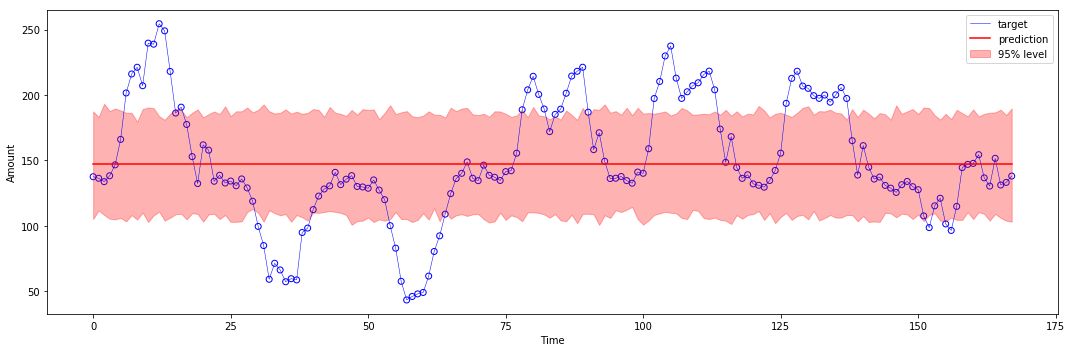

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


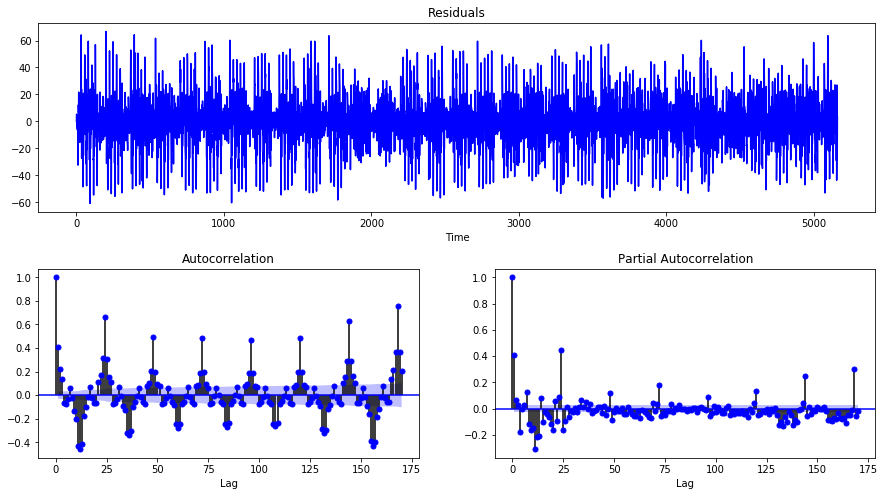

In [53]:
hw_model = load('hw_model')
hw_res = load('hw_res')

plot_predictions(hw_res.resid, hw_model, train, test, 168, 'hw_wo_seasonal')
plot_residual_analysis(hw_res.resid, 'hw_wo_seasonal')

In [46]:
hw_model = load('hw_model')
hw_res = load('hw_res')
hw_preds = hw_model.predict(hw_model.params, start=len(train), end=len(train)+len(test)-1)
show_metrics(hw_res.resid, hw_preds, test)

Training:  MSE=326.808, MAE=13.031
---
Test:      MSE=2637.536, MAE=38.217


### With seasonal component

In [ ]:
"""hw_seasonal_model = ExponentialSmoothing(train, trend='add', damped=True, seasonal='add', seasonal_periods=168)
hw_seasonal_res = hw_seasonal_model.fit()

save(hw_seasonal_model, 'hw_seasonal_model')
save(hw_seasonal_res, 'hw_seasonal_res')"""

100%|██████████| 168/168 [01:18<00:00,  2.12it/s]


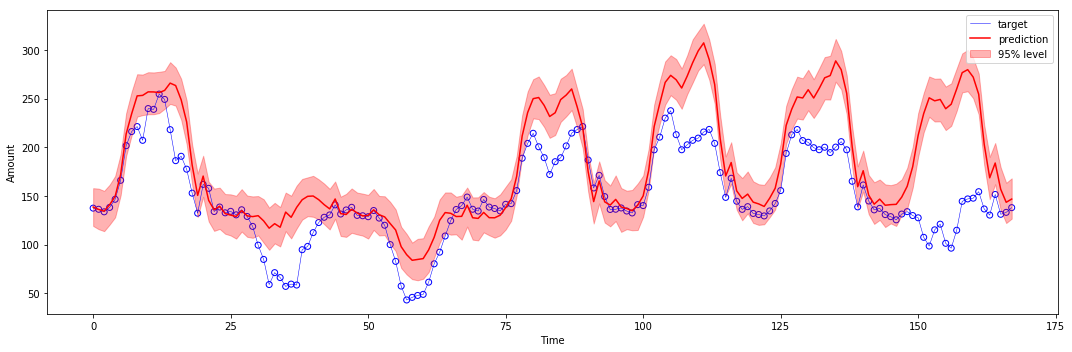

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


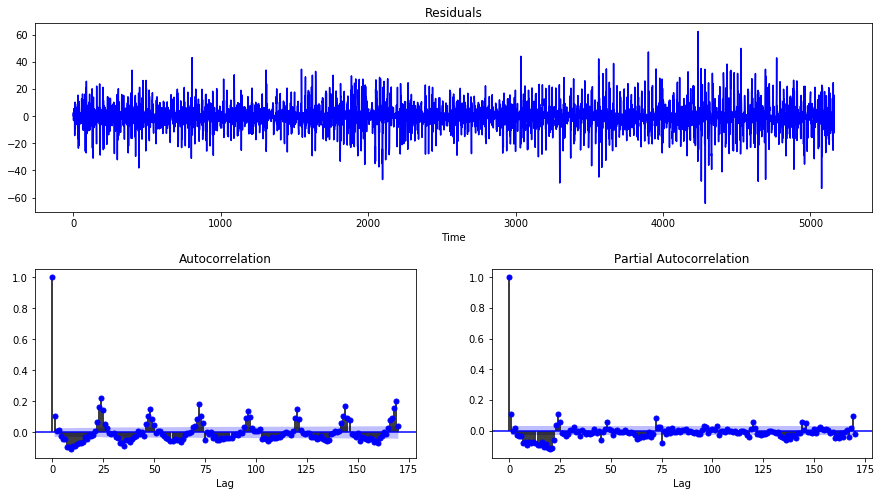

In [54]:
hw_seasonal_model = load('hw_seasonal_model')
hw_seasonal_res = load('hw_seasonal_res')

plot_predictions(hw_seasonal_res.resid, hw_seasonal_model, train, test, 168, 'hw_seasonal')
plot_residual_analysis(hw_seasonal_res.resid, 'hw_seasonal')

In [55]:
hw_seasonal_preds = hw_seasonal_model.predict(hw_seasonal_model.params, start=len(train), end=len(train)+len(test)-1)
show_metrics(hw_seasonal_res.resid, hw_seasonal_preds, test)

Training:  MSE=90.483, MAE=6.349
---
Test:      MSE=1611.533, MAE=26.800


In [12]:
"""hw_seasonal_mul_model = ExponentialSmoothing(train, trend='add', damped=True, seasonal='mul', seasonal_periods=168)
hw_seasonal_mul_res = hw_seasonal_mul_model.fit()

save(hw_seasonal_mul_model, 'hw_seasonal_mul_model')
save(hw_seasonal_mul_res, 'hw_seasonal_mul_res')"""

100%|██████████| 168/168 [01:19<00:00,  2.12it/s]


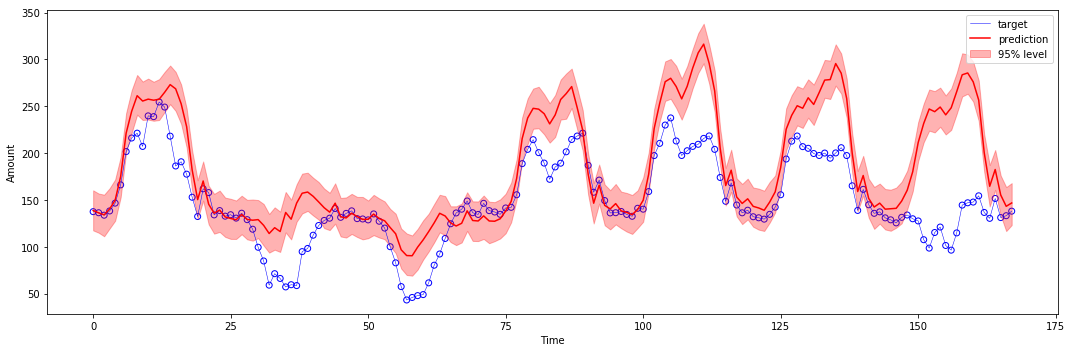

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


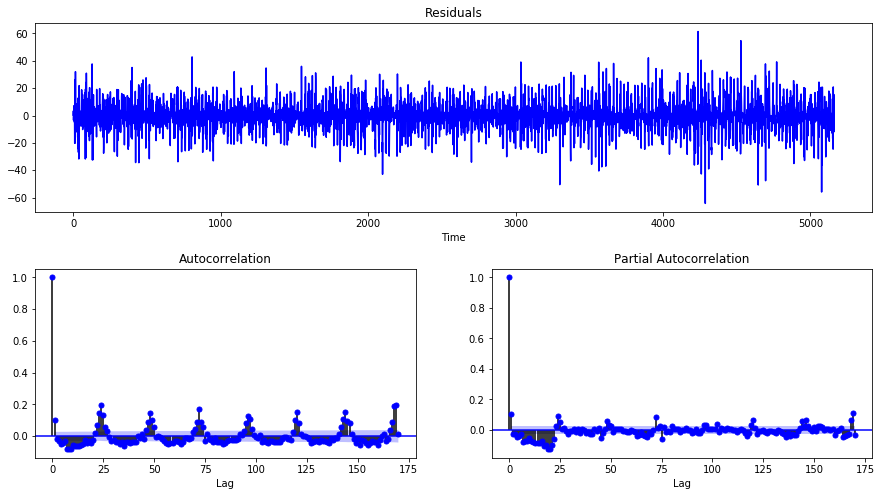

In [56]:
hw_seasonal_mul_model = load('hw_seasonal_mul_model')
hw_seasonal_mul_res = load('hw_seasonal_mul_res')

plot_predictions(hw_seasonal_mul_res.resid, hw_seasonal_mul_model, train, test, 168, 'hw_seasonal_mul')
plot_residual_analysis(hw_seasonal_mul_res.resid, 'hw_seasonal_mul')

In [57]:
hw_seasonal_mul_preds = hw_seasonal_mul_model.predict(hw_seasonal_mul_model.params, start=len(train), end=len(train)+len(test)-1)
show_metrics(hw_seasonal_mul_res.resid, hw_seasonal_mul_preds, test)

Training:  MSE=93.122, MAE=6.523
---
Test:      MSE=1801.081, MAE=28.766


100%|██████████| 168/168 [01:20<00:00,  2.17it/s]


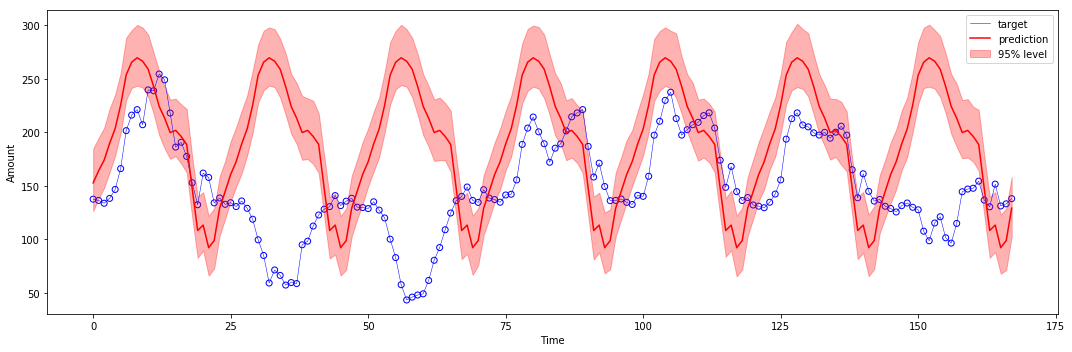

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


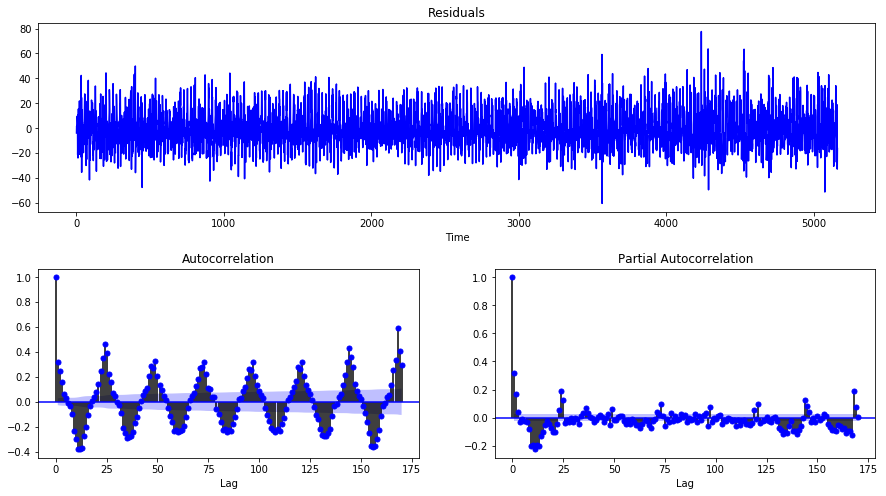

In [58]:
hw_seasonal24_model = load('hw_seasonal24_model')
hw_seasonal24_res = load('hw_seasonal24_res')

plot_predictions(hw_seasonal24_res.resid, hw_seasonal24_model, train, test, 168, 'hw_seasonal24')
plot_residual_analysis(hw_seasonal24_res.resid, 'hw_seasonal24')

In [59]:
hw_seasonal24_preds = hw_seasonal24_model.predict(hw_seasonal24_model.params, start=len(train), end=len(train)+len(test)-1)
show_metrics(hw_seasonal24_res.resid, hw_seasonal24_preds, test)

Training:  MSE=196.662, MAE=10.847
---
Test:      MSE=6268.145, MAE=59.743


## ARIMA model

In [18]:
def plot_acf_pacf(data, name, lag=170):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    plot_acf(data, lags=lag, ax=ax[0])
    ax[0].set_xlabel('Lag')
    plot_pacf(data, lags=lag, ax=ax[1])
    ax[1].set_xlabel('Lag')
    plt.tight_layout()
    plt.savefig('{}.png'.format(name), dpi=300)
    plt.show()
def plot_qqplot(resid, name):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    fig = qqplot(resid, line='q', ax=ax, fit=True)
    plt.tight_layout()
    plt.savefig('{}.png'.format(name), dpi=300)
    plt.show()

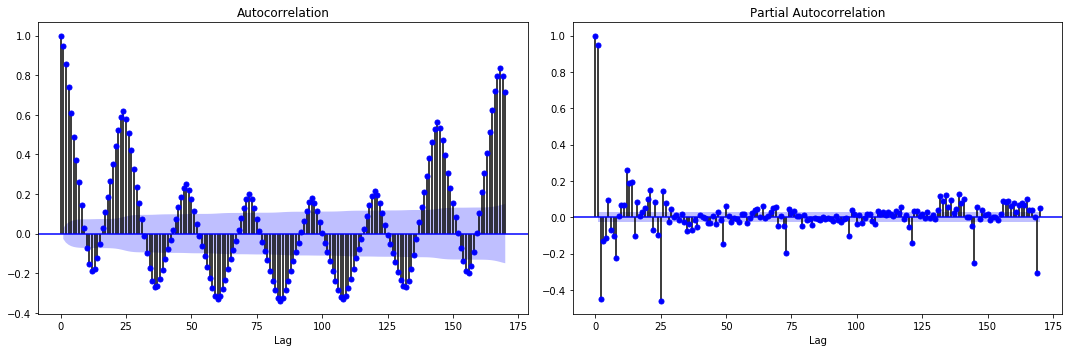

In [38]:
plot_acf_pacf(train, 'acf_pacf_data')

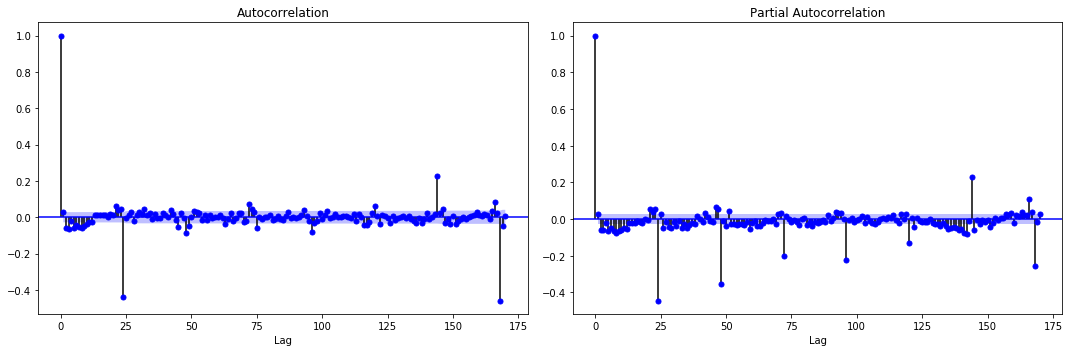

In [39]:
train_diff = apply_differencing_filters(train, [1,24,168])
plot_acf_pacf(train_diff, 'acf_pacf_data_diff')

In [22]:
arma20_model = ARMA(train, (2,0))
arma20_model_res = arma20_model.fit()

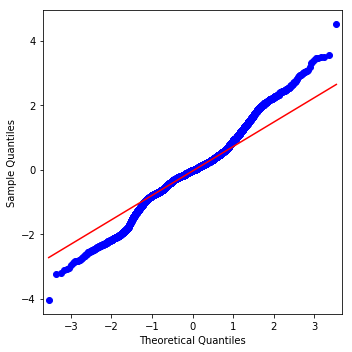

In [31]:
plot_qqplot(arma20_model_res.resid, 'qqplot_arma20')

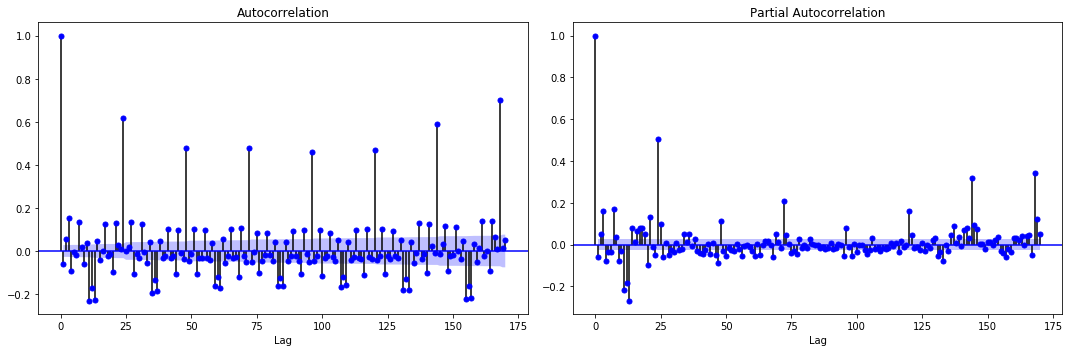

In [40]:
plot_acf_pacf(arma20_resid, 'acf_pacf_arma20')

In [37]:
arma24_model = ARMA(train, (25,0))
arma24_model_res = arma24_model.fit()

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

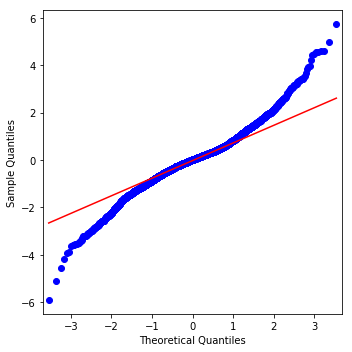

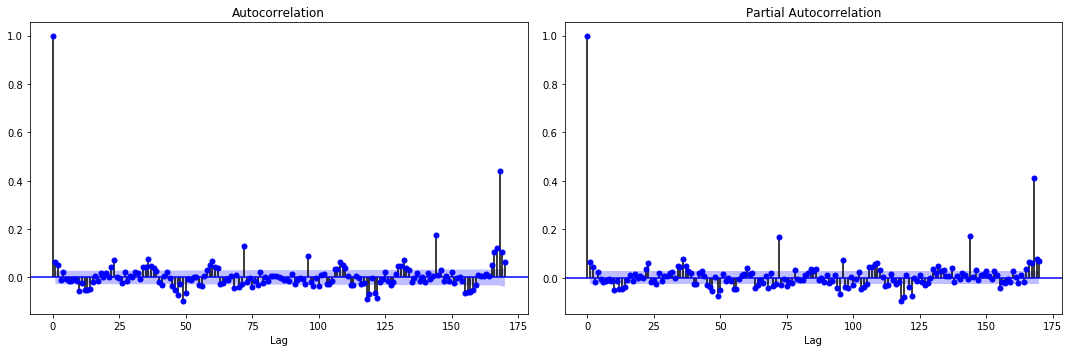

In [38]:
plot_qqplot(arma24_model_res.resid, 'qqplot_arma25')
plot_acf_pacf(arma24_model_res.resid, 'acf_pacf_arma25')

In [35]:
arma2_9_model = ARMA(train, (2,9))
arma2_9_model_res = arma2_9_model.fit()

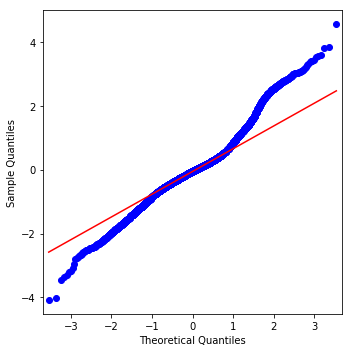

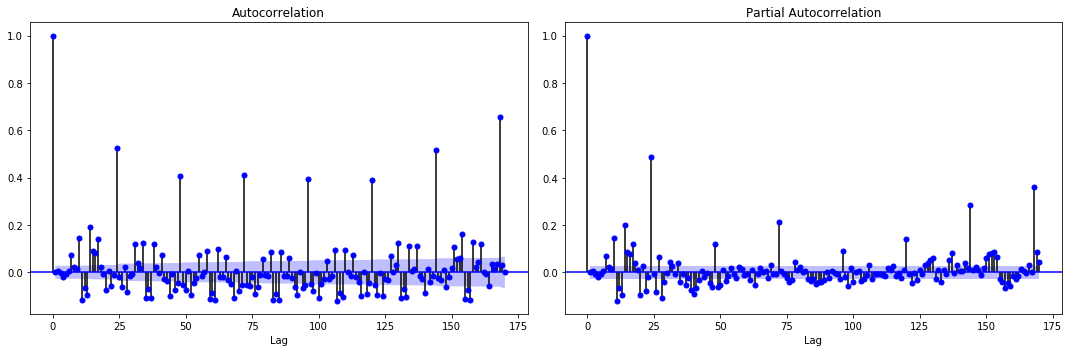

In [36]:
plot_qqplot(arma2_9_model_res.resid, 'qqplot_arma2_9')
plot_acf_pacf(arma2_9_model_res.resid, 'acf_pacf_arma2_9')

## Linear Regression

In [63]:
# create dataframe with the data
date_rng = pd.date_range(start='2014-10-05', end='2015-06-01', freq='H', closed='left')
df = pd.DataFrame(date_rng, columns=['date'])
df['consumption'] = m
df.head(5)

,date,consumption
0,2014-10-05 00:00:00,129.336728
1,2014-10-05 01:00:00,134.729526
2,2014-10-05 02:00:00,130.954735
3,2014-10-05 03:00:00,128.923580
4,2014-10-05 04:00:00,127.021535


In [64]:
# create features

# day
df['day'] = df['date'].map(lambda date: date.dayofweek)

# hour
df['hour'] = df['date'].map(lambda date: date.hour)

# holidays
christmas_holidays = pd.date_range(start='2014-12-18', end='2015-01-04', freq='H')
easter_holidays = pd.date_range(start='2015-03-25', end='2015-04-03', freq='H')
holidays = christmas_holidays.union(easter_holidays)
df['holiday'] = df['date'].map(lambda date: 1 if date in holidays else 0)

df.head()

,date,consumption,day,hour,holiday
0,2014-10-05 00:00:00,129.336728,6,0,0
1,2014-10-05 01:00:00,134.729526,6,1,0
2,2014-10-05 02:00:00,130.954735,6,2,0
3,2014-10-05 03:00:00,128.923580,6,3,0
4,2014-10-05 04:00:00,127.021535,6,4,0


In [65]:
# do one-hot encoding on all categorical features

df = pd.get_dummies(data=df, prefix=['day'], columns=['day'])
df = pd.get_dummies(data=df, prefix=['hour'], columns=['hour'])
df.head()

,date,consumption,holiday,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2014-10-05 00:00:00,129.336728,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2014-10-05 01:00:00,134.729526,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2014-10-05 02:00:00,130.954735,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2014-10-05 03:00:00,128.923580,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2014-10-05 04:00:00,127.021535,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Linear regression

scaler = MinMaxScaler(feature_range=(0,1))
y = df[['consumption']].as_matrix()
y_log = scaler.fit_transform(y)

X_train = df.iloc[:-574,-32:].as_matrix()
X_test = df.iloc[-574:,-32:].as_matrix()
y_train = y[:-574]
y_test = y[-574:]
y_log_train = y_log[:-574]
y_log_test = y_log[-574:]

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg_log = linear_model.LinearRegression()
reg_log.fit(X_train, y_log_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
y_log_pred_train = scaler.inverse_transform(reg_log.predict(X_train))
y_log_pred_test = scaler.inverse_transform(reg_log.predict(X_test))

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


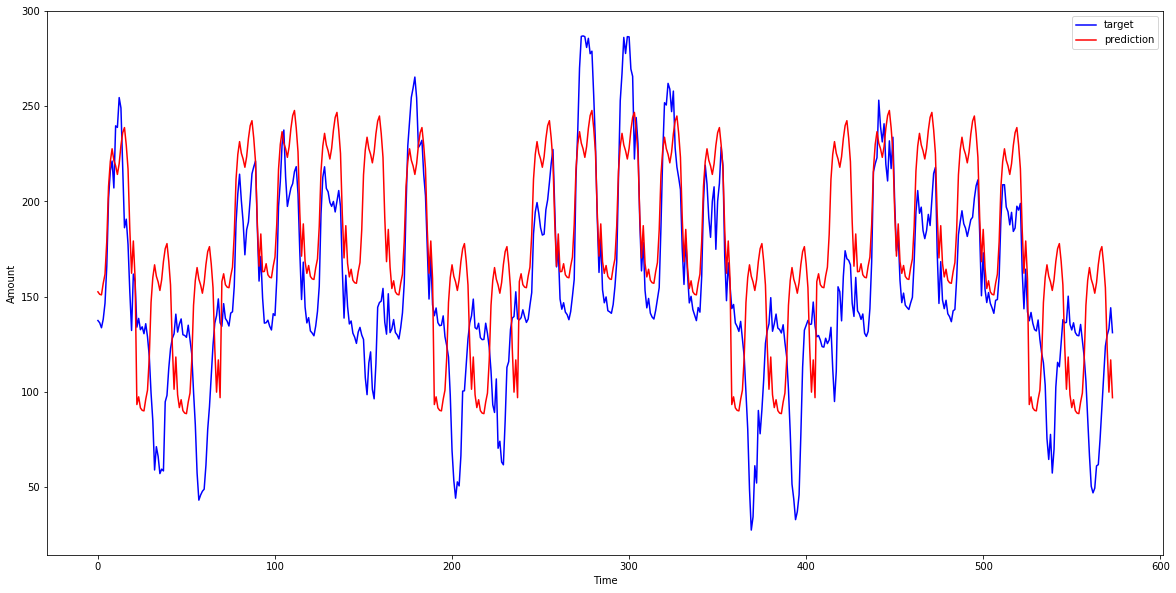

In [70]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(y_test, label = 'target', color='blue')
ax.plot(y_log_pred_test, label = 'prediction', color='red')
plt.legend()
plt.ylabel('Amount')
plt.xlabel('Time')
plt.show()

In [71]:
print('Training:       MSE={:.3f}, MAE={:.3f}'.format(mean_squared_error(y_train, y_pred_train), mean_absolute_error(y_train, y_pred_train)))
print('Training (log): MSE={:.3f}, MAE={:.3f}'.format(mean_squared_error(y_train, y_log_pred_train), mean_absolute_error(y_train, y_log_pred_train)))
print('---')
print('Test:           MSE={:.3f}, MAE={:.3f}'.format(mean_squared_error(y_test, y_pred_test), mean_absolute_error(y_test, y_pred_test)))
print('Test (log):     MSE={:.3f}, MAE={:.3f}'.format(mean_squared_error(y_test, y_log_pred_test), mean_absolute_error(y_test, y_log_pred_test)))

Training:       MSE=1210.132, MAE=27.996
Training (log): MSE=1209.975, MAE=28.007
---
Test:           MSE=2223.933, MAE=37.053
Test (log):     MSE=2226.961, MAE=37.115
